In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import chi2_contingency, mannwhitneyu

In [2]:
# Gets src path 
src_path = os.path.dirname(os.getcwd())

# Adds src_path if it doesn't exist in sys.path (to access utils)
if os.path.exists(src_path) and src_path not in sys.path:
    sys.path.append(src_path)
    
import src.utils.data_tools as dt
import src.utils.viz_tools as vt

In [3]:
df_main = pd.read_csv('./src/data/processed/main_data.csv')
df_bm = pd.read_csv('./src/data/processed/biomarker_data.csv')
df_adni = pd.read_csv('./src/data/processed/adni_clean_data.csv')

### Data for testing

In [12]:
main_clasif = dt.classify_by_cardinality(df_main)
column_selection = main_clasif.loc[main_clasif['Suggested Type'].isin(['Binary', 'Categorical'])]
categorical_main = column_selection.index.to_list()

new_labels = {
    'Gender': ['Male', 'Female'],
    'Ethnicity': ['Caucasian', 'African American', 'Asian', 'Other'],
    'Education_lv': ['None', 'High School', 'Bachelor\'s', 'Higher'],
    'Smoking': ['No', 'Yes'],
    'Family_History_Alzheimers': ['No', 'Yes'],
    'CVD': ['No', 'Yes'],
    'Diabetes': ['No', 'Yes'],
    'Depression': ['No', 'Yes'],
    'Head_Injury': ['No', 'Yes'],
    'Hypertension': ['No', 'Yes'],
    'Memory_Complaints': ['No', 'Yes'],
    'Behavioral_Problems': ['No', 'Yes'],
    'Confusion': ['No', 'Yes'],
    'Disorientation': ['No', 'Yes'],
    'Personality_Changes': ['No', 'Yes'],
    'Difficulty_Completing_Tasks': ['No', 'Yes'],
    'Forgetfulness': ['No', 'Yes'],
    'DX': ['No AD', 'AD']
}

In [5]:
main_classification = dt.classify_by_cardinality(df_main)
column_selection = main_classification.loc[main_classification['Suggested Type'].isin(['Numerical (discrete)', 'Numerical (continuous)'])]
numerical_main = column_selection.index.to_list()
numerical_main.append('DX')

In [6]:
bm_classification = dt.classify_by_cardinality(df_bm)
column_selection = bm_classification.loc[bm_classification['Suggested Type'].isin(['Binary', 'Categorical'])]
categorical_bm = column_selection.index.to_list()

new_labels = {
    'Gender': ['Male', 'Female'],
    'Smoking': ['No', 'Yes'],
    'Drinking': ['No', 'Yes'],
    'CVD': ['No', 'Yes'],
    'Hypertension': ['No', 'Yes'],
    'Diabetes': ['No', 'Yes'],
    'DX': ['CU', 'MCI', 'AD']
}

In [7]:
bm_classification = dt.classify_by_cardinality(df_bm)
column_selection = bm_classification.loc[bm_classification['Suggested Type'].isin(['Numerical (discrete)', 'Numerical (continuous)'])]
numerical_bm = column_selection.index.to_list()

In [8]:
adni_classification = dt.classify_by_cardinality(df_adni)
column_selection = adni_classification.loc[adni_classification['Suggested Type'].isin(['Binary', 'Categorical'])]
categorical_adni = column_selection.index.to_list()

In [16]:
def adjust_palette(palette, n_categories):
    """
    Adjusts a color palette to match the number of categories.

    Parameters:
        palette (list or str): The original palette, which can be a list of colors or a seaborn palette name.
        n_categories (int): The number of categories that need colors.

    Returns:
        list: A list of colors adjusted to match the number of categories.
    """
    if isinstance(palette, (list, sns.palettes._ColorPalette)):
        # If palette is a list or a ColorPalette instance, adjust length to number of categories
        return palette[:n_categories]
    elif isinstance(palette, str):
        # If palette is the name of a Seaborn palette, return the string
        return palette
    else:
        raise ValueError('Palette param must be a list, ColorPalette instance or palette name (str).')


### Categorical functions

In [10]:
def plot_categorical_distribution(df, cat_columns, n_columns = 3, *, relative = False, show_values = False, custom_labels = False, rotation = 45, palette = 'viridis'):
    '''   
    Generates bar plots to visualize the distribution of categorical variables in a given DataFrame. The function allows for plotting either the absolute or relative frequencies of the categories for each specified column. Additionally, it provides options to display frequency values directly on the bars, apply custom labels, rotate the x-axis labels, and choose a color palette. The layout of the plots is automatically adjusted based on the number of columns specified by the user.

    Parameters:
        df (pd.DataFrame): 
            DataFrame containing the data to plot. It should include the categorical columns specified in `cat_columns`.
        
        cat_columns (list of str): 
            List of column names (strings) corresponding to the categorical variables to visualize.
        
        n_columns (int, optional, default=3):
            Number of columns for the subplot grid. This value can be 1, 2, or 3. If the number of categorical columns (`cat_columns`) is fewer than `n_columns`, the grid will automatically adjust to use the exact number of columns needed. 

        relative (bool, optional, default=False): 
            If True, the function will plot the relative frequencies of the categories. If False, it will plot the absolute frequencies.

        show_values (bool, optional, default=False): 
            If True, the function will display the frequency values directly on top of the bars in the plot.

        custom_labels (dict of {str: list}, optional, default=False): 
            If provided, this dictionary should map column names to lists of custom labels to use for the x-axis ticks. The keys should be column names from `cat_columns`, and the values should be lists of labels corresponding to the categories in that column.

        rotation (int, optional, default=45): 
            Angle (in degrees) to rotate the x-axis labels for better readability.

        palette (str, optional, default='viridis'): 
            Color palette to use for the bars. If an empty string is provided, 'viridis' will be used as the default.

    Returns:
        None: 
            This function does not return any objects. It generates and displays a set of bar plots showing the frequency distributions of the specified categorical variables.
    '''

    # Validate number of specified columns
    if n_columns not in [1, 2, 3]:
        raise ValueError('n_columns must be 1, 2 or 3.')
    
    # Determine the number of columns and rows needed for the subplot grid
    n_plots = len(cat_columns)
    if n_plots in [1, 2]:
        n_columns = n_plots
    n_rows = (n_plots // n_columns) + (1 if n_plots % n_columns != 0 else 0)
    
    # Create the base figure and a grid of subplots with the specified size
    fig, axs = plt.subplots(n_rows, n_columns, figsize = (5 * n_columns, 5 * n_rows))
    axs = axs.flatten() if n_plots > 1 else [axs]
    
    # Set figure title and update palette if string is empty
    plt.suptitle('Categorical Distribution', ha = 'center', y = 1, fontproperties = {'weight': 600, 'size': 14})
    
    if palette == '':
        palette = 'viridis'
    
    # Plot the frequency distribution for each categorical column
    for i, col in enumerate(cat_columns):
        ax = axs[i]
        if relative:
            # Calculate and plot the relative frequencies
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x = serie.index, y = serie, ax = ax, palette = adjust_palette(palette, len(serie)), hue = serie.index, legend = False)
            ax.set_ylabel('Relative Frequency')
        else:
            # Calculate and plot the absolute frequencies
            serie = df[col].value_counts()
            sns.barplot(x = serie.index, y = serie, ax = ax, palette = adjust_palette(palette, len(serie)), hue = serie.index, legend = False)
            ax.set_ylabel('Count')

        # Set the title, ticks, grid and spine
        ax.set_title(f'{col}', ha = 'center', y = 1.025)
        ax.set_xlabel('')
        ax.tick_params(colors = '#565656')
        ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
        ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
        ax.set_axisbelow(True)
        ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        
        if custom_labels:
            # Set custom labels
            labels = custom_labels[col]
            ticks = range(len(labels))
            ax.set_xticks(ticks = ticks, labels = labels)

        if show_values:
            # Annotate each bar with its height (the frequency value)
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}' if relative else f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
                
    # Hide any unused subplots if the number of categorical columns is odd
    for j in range(i + 1, n_rows * n_columns):
        axs[j].axis('off')
        
    # Adjust the layout to prevent overlap and display the plots
    plt.tight_layout(h_pad = 3, w_pad = 5)
    plt.show()

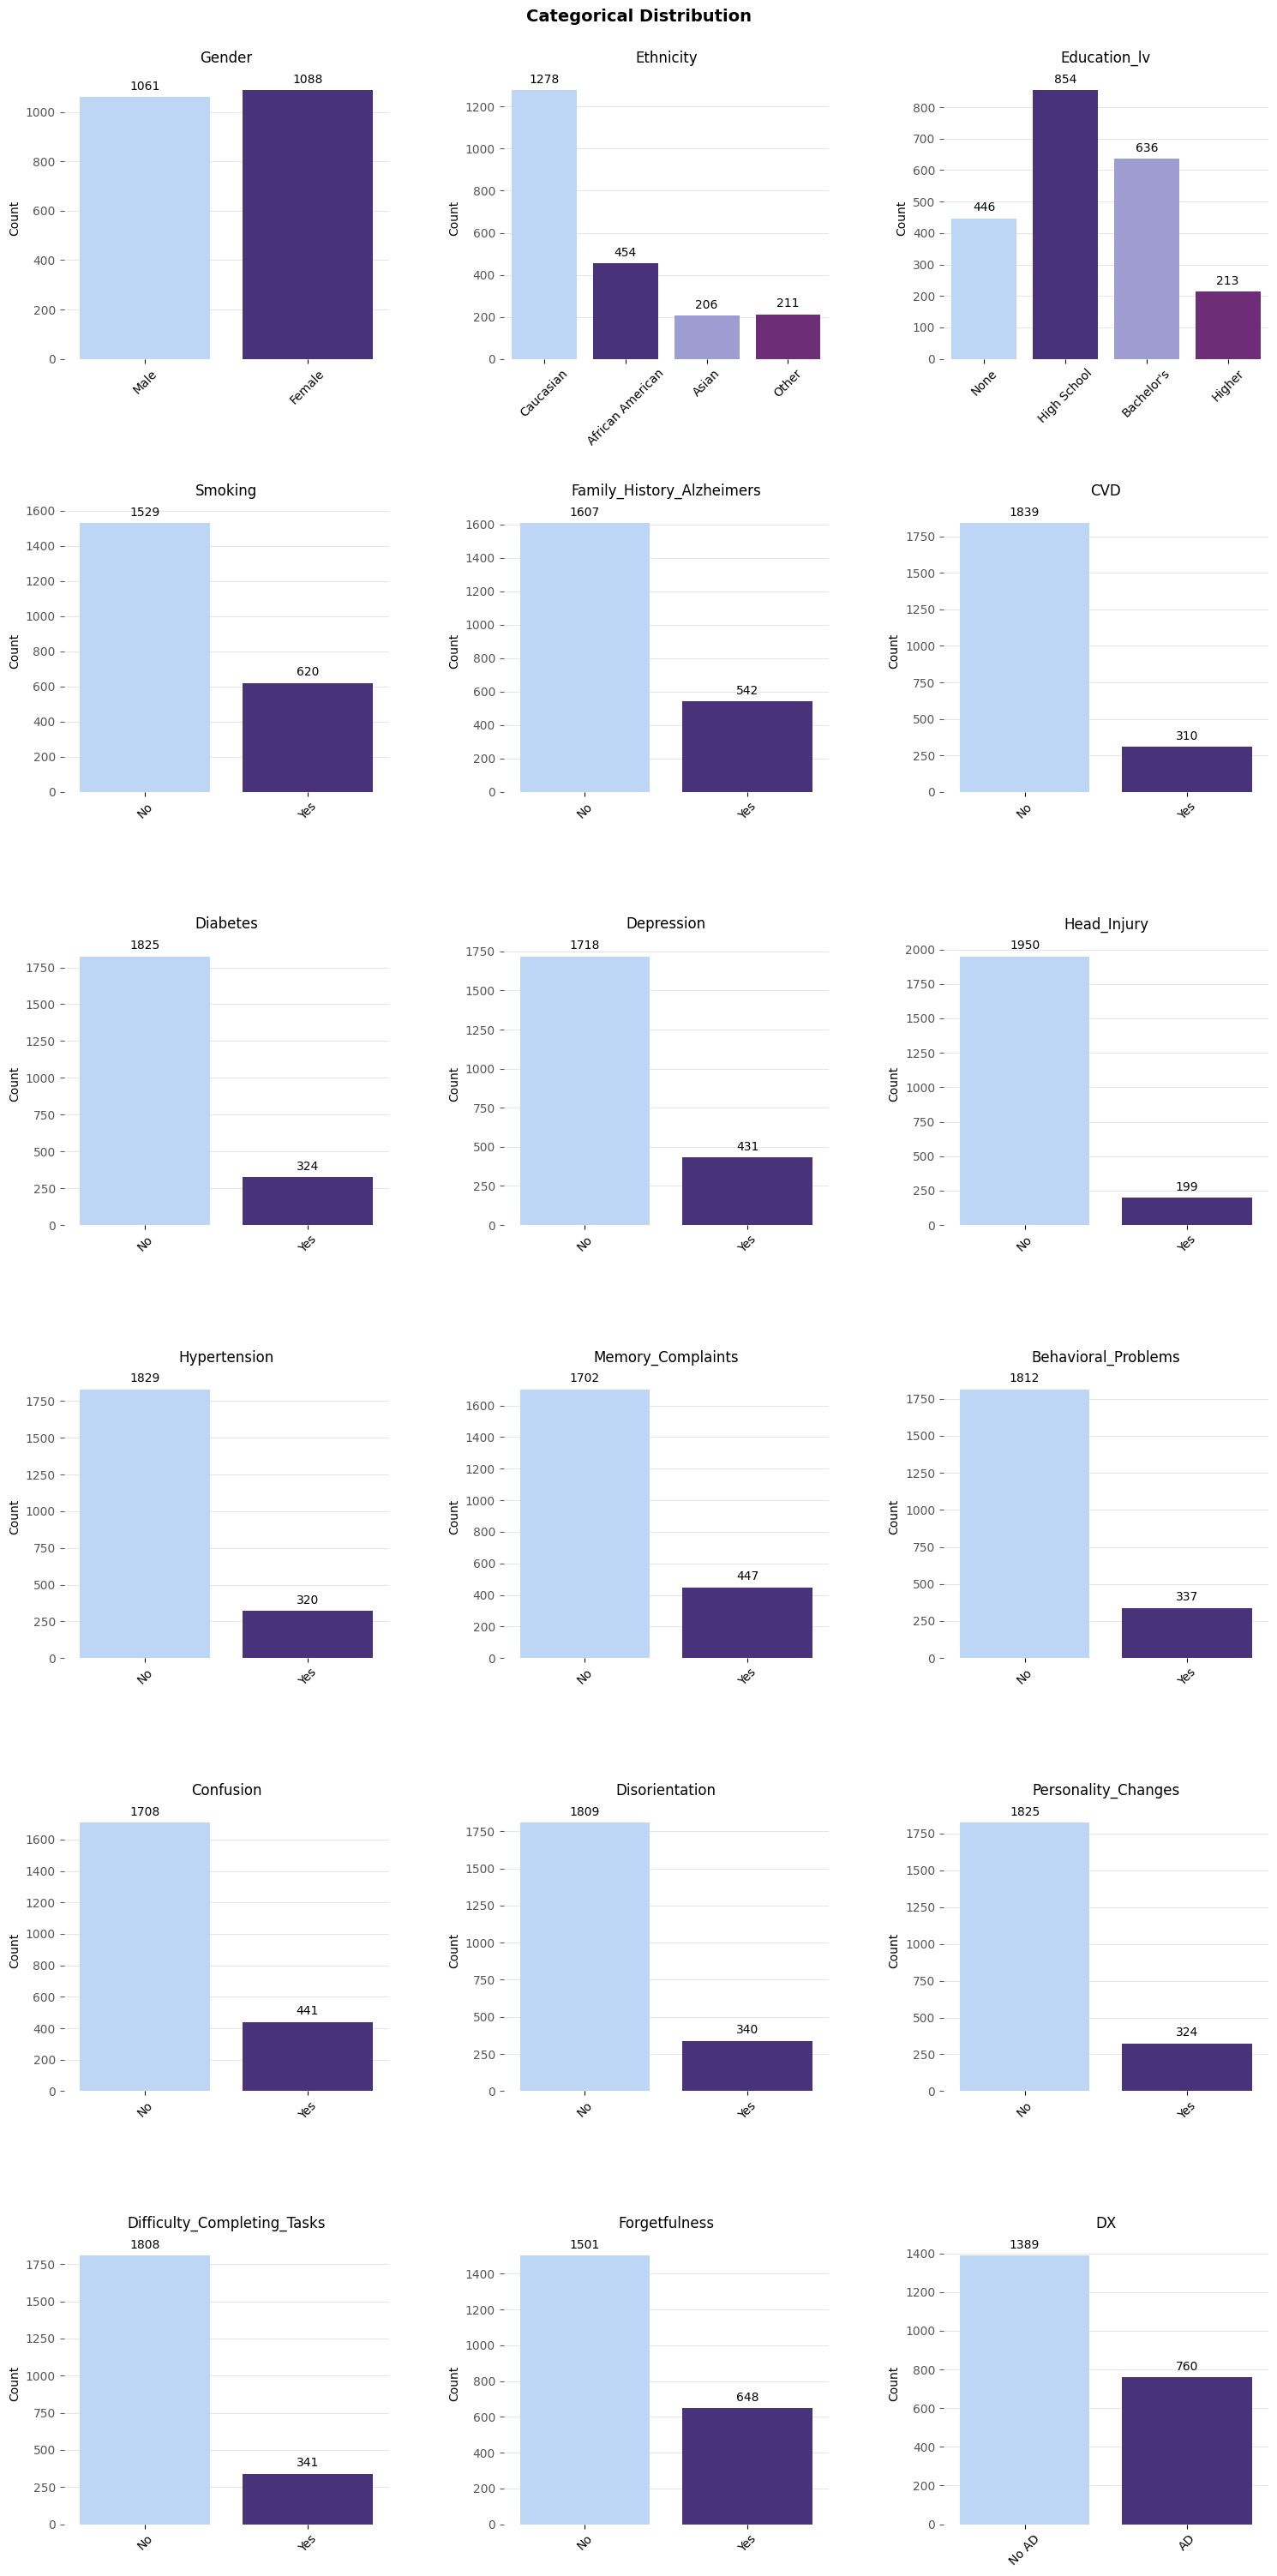

In [13]:
plot_categorical_distribution(df_main, categorical_main, custom_labels=new_labels, palette = ['#b4d5ff', '#432786', '#9694DB', '#772183', '#C46CBE'], show_values=True)

### Relationships scipy.stats

In [ ]:
def categorical_correlation_test(df, cat_col1, cat_cols2):
    '''
    Computes the chi-squared correlation between a primary categorical column and one or more secondary categorical columns. It identifies columns from `cat_cols2` that are significantly associated with `cat_col1` based on a p-value threshold of 0.05. The function also returns detailed information for each chi-squared test conducted.

    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the categorical columns to be analyzed.
        
        cat_col1 : str
            The name of the primary categorical column in `df` for which correlations with other columns are assessed.
        
        cat_cols2 : str or list of str
            A column name or a list of column names in `df` to compare with `cat_col1`. The function will compute the chi-squared
            statistic for each column in this list against `cat_col1`.

    Returns:
        correlated_cols : dict
            A dictionary where the keys are the names of the columns from `cat_cols2` that have a significant association
            (p-value < 0.05) with `cat_col1`, and the values are their corresponding p-values.
        
        all_info : dict
            A dictionary containing detailed results for each chi-squared test conducted. The keys are the names of the columns
            from `cat_cols2`, and the values are dictionaries with the following keys:
                - 'chi2': The chi-squared statistic.
                - 'p': The p-value of the test.
                - 'dof': The degrees of freedom of the test.
                - 'expected': The expected frequencies table computed for the chi-squared test.
    
    Notes:
        - If `cat_cols2` is passed as a string, it will be converted into a list containing that string.
        - The function skips comparing `cat_col1` with itself to avoid meaningless self-correlation.
        - The chi-squared test is only valid for categorical data with sufficient sample size in each category.
    '''
    
    # Validate cat_cols2 type; if a string is passed, convert it into a list
    if isinstance(cat_cols2, str):
        cat_cols2 = [cat_cols2]
        
    # Initialize dictionaries to store results
    correlated_cols = {}
    all_info = {}
    
    # Loop through each column in cat_cols2 to compare with cat_col1
    for col in cat_cols2:
        # Contingency table and chi-squared test
        contingency_table = pd.crosstab(df[cat_col1], df[col], margins = False)
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Check if the p-value is significant and avoid self-correlation
        if p < 0.05 and col != cat_col1:
            correlated_cols[col] = p
            
        # Store detailed test results for the current column
        all_info[col] = {'chi2': chi2, 'p': p, 'dof': dof, 'expected': expected}
        
    # Return the dictionary of correlated columns and the detailed information
    return correlated_cols, all_info

In [ ]:
categorical_correlation_test(df_main, 'DX', categorical_main)[0]

In [ ]:
main_classification = dt.classify_by_cardinality(df_main)
column_selection = main_classification.loc[main_classification['Suggested Type'].isin(['Numerical (discrete)', 'Numerical (continuous)'])]
numerical_main = column_selection.index.to_list()
numerical_main.append('DX')
num_main = df_main[numerical_main]

In [ ]:
def numerical_correlation_test(df, target, num_cols, alpha = 0.05):
    """
    Performs the Mann-Whitney U test to determine if there are significant differences
    in the distributions of numerical columns between two groups defined by a binary target variable.

    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the data.
        target : str
            The name of the binary target variable (categorical) used to split the data into two groups.
        num_cols : list or str
            A list of numerical columns to test, or a single column name as a string.
        alpha : float, optional
            The significance level to determine if the p-value indicates a statistically significant difference, by default 0.05.
    
    Returns:
        correlated_cols : dict
            A dictionary containing the numerical columns that show a statistically significant difference
            between the two groups, along with their respective p-values.
        all_info : dict
            A dictionary containing detailed test results (U statistic and p-value) for all tested columns.
    """

    # Validate num_cols type; if a single string is passed, convert it into a list
    if isinstance(num_cols, str):
        num_cols = [num_cols]

    # Initialize dictionaries to store results
    correlated_cols = {}
    all_info = {}

    # Retrieve the unique values of the binary target variable
    target_values = df[target].value_counts().index.to_list()

    # Validate that the target variable has only two unique values
    if len(target_values) != 2:
        raise ValueError(f'The target variable "{target}" must have exactly two unique values.')

    # Split the DataFrame into two groups based on the binary target variable
    group_a = df[df[target] == target_values[0]]
    group_b = df[df[target] == target_values[1]]

    # Loop through each numerical column in num_cols to compare its distribution between the two groups
    for col in num_cols:
        # Perform the Mann-Whitney U test
        u_stat, p_value = mannwhitneyu(group_a[col], group_b[col])

        # Check if the p-value is below the significance threshold and store the column if it is significant
        if p_value < alpha and col != target:
            correlated_cols[col] = p_value

        # Store the U statistic and p-value
        all_info[col] = {'u_stat': u_stat, 'p_value': p_value}

    # Return the dictionary of significant correlations and the detailed test results
    return correlated_cols, all_info


In [ ]:
bm_classification = dt.classify_by_cardinality(df_bm)
column_selection = bm_classification.loc[bm_classification['Suggested Type'].isin(['Numerical (discrete)', 'Numerical (continuous)'])]
numerical_bm = column_selection.index.to_list()
numerical_bm.append('DX')
num_bm = df_bm[numerical_bm].copy()
num_bm['DX'] = num_bm['DX'].apply(lambda x: 1 if x == 'AD' else 0)

In [ ]:
numerical_correlation_test(num_bm, 'DX', numerical_bm)[0]

### Relationships

In [ ]:
def plot_numerical_correlation(df, target, rotation=60, color=None):
    """
    Plots a bar chart representing the Pearson correlation between the target variable
    and all other numerical variables in the given DataFrame.

    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the data.
        target : str
            The name of the target variable (must be numeric).
        rotation : int, optional
            The angle of rotation for the x-axis labels, by default 60.
        color : str or None, optional
            The color for the bars in the plot. If None, a default color will be used, by default None.

    Returns:
        None
            The function displays a plot but does not return any value.
    """

    # Compute the Pearson correlation between the target and all other numeric variables
    correlation = df.corr(numeric_only=True)[target].drop(target).sort_values()

    # Calculate the y-axis limit to include all correlation values comfortably
    y_limit = correlation.abs().max() + 0.05

    # Generate figure
    plt.figure()
    ax = correlation.plot(kind = 'bar', width = 0.7, color = color if color else '#74BBFF')

    # Set title, y-label and y-limit
    ax.set(title = f'Pearson Correlation with {target}', ylabel = 'Pearson Correlation', ylim = [-y_limit, y_limit])

    # Set the color for the tick labels and rotate the x-axis labels
    ax.tick_params(colors = '#565656')
    ax.tick_params(axis = 'x', rotation=rotation, colors = 'k')

    # Remove the right and top spines and set color for the remaining spines
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('#565656')

    # Align the x-axis labels to the right for better readability
    ax.set_xticklabels(correlation.index, rotation = rotation, ha = 'right')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
plot_numerical_correlation(df_main[numerical_main], 'DX')

In [20]:
def plot_categorical_relationship_stacked(df, cat_col1, cat_cols2, n_columns = 3, *, relative = False, rotation = 0, palette = 'viridis'):
    # Validate cat_cols2 type
    if isinstance(cat_cols2, str):
        cat_cols2 = [cat_cols2]
    
    # Validate number of specified columns
    if n_columns not in [1, 2, 3]:
        raise ValueError('n_columns must be 1, 2 or 3.')
    
    # Determine the number of columns and rows needed for the subplot grid
    n_plots = len(cat_cols2) - 1 if cat_col1 in cat_cols2 else len(cat_cols2)
    if n_plots in [1, 2]:
        n_columns = n_plots
    n_rows = (n_plots // n_columns) + (1 if n_plots % n_columns != 0 else 0)
    
    # Create the base figure and a grid of subplots with the specified size
    fig, axs = plt.subplots(n_rows, n_columns, figsize = (7 * n_columns, 5 * n_rows))
    plt.subplots_adjust(right = 0.75)
    axs = axs.flatten() if n_plots > 1 else [axs]
    
    # Set figure title and update palette if string is empty
    plt.suptitle(f'Categorical Relationships (x = {cat_col1})', ha = 'center', y = 1, fontproperties = {'weight': 600, 'size': 14})
    
    if palette == '':
        palette = 'viridis'
        
    # List to store contingency tables
    contingency_tables = []
    
    # Track the number of actual plots created
    i = 0
    
    # Plot the frequency distribution for each categorical column
    for col in cat_cols2:
        # Skip if comparing the variable with itself
        if col == cat_col1:
            continue  
        
        ax = axs[i]
        if relative:
            # Calculate and plot the relative frequencies
            contingency_table = pd.crosstab(df[cat_col1], df[col], normalize = 'index', margins = False)
            contingency_table.plot(kind = 'bar', stacked = True, color = adjust_palette(palette, df[col].nunique()), ax = ax)
            ax.set_ylabel('Relative Frequency')
        else:
            # Calculate and plot the absolute frequencies
            contingency_table = pd.crosstab(df[cat_col1], df[col], margins = False)
            contingency_table.plot(kind = 'bar', stacked = True, color = adjust_palette(palette, df[col].nunique()), ax = ax)
            ax.set_ylabel('Count')
        
        # Store the contingency table
        contingency_tables.append(contingency_table)
        
        # Set the title, ticks, grid and spine
        ax.set_title(f'{col} and {cat_col1}', ha = 'center', y = 1.025)
        ax.set_xlabel('')
        ax.tick_params(colors = '#565656')
        ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
        ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
        ax.set_axisbelow(True)
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['bottom']].set_color('#CFD2D6')
        ax.legend(title = f'{col}', bbox_to_anchor = (1.03, 1), loc = 'upper left' )
        
        # Increment plot index only when a plot is created
        i += 1
    
        
    # Hide any unused subplots if the number of categorical columns is odd
    for j in range(i, n_rows * n_columns):
        axs[j].axis('off')
        
    # Adjust the layout to prevent overlap and display the plots
    plt.tight_layout(h_pad = 3)
    plt.show()
    
    return contingency_tables, fig
    

In [18]:
palette = ['#b4d5ff', '#432786', '#9694DB', '#772183', '#C46CBE']

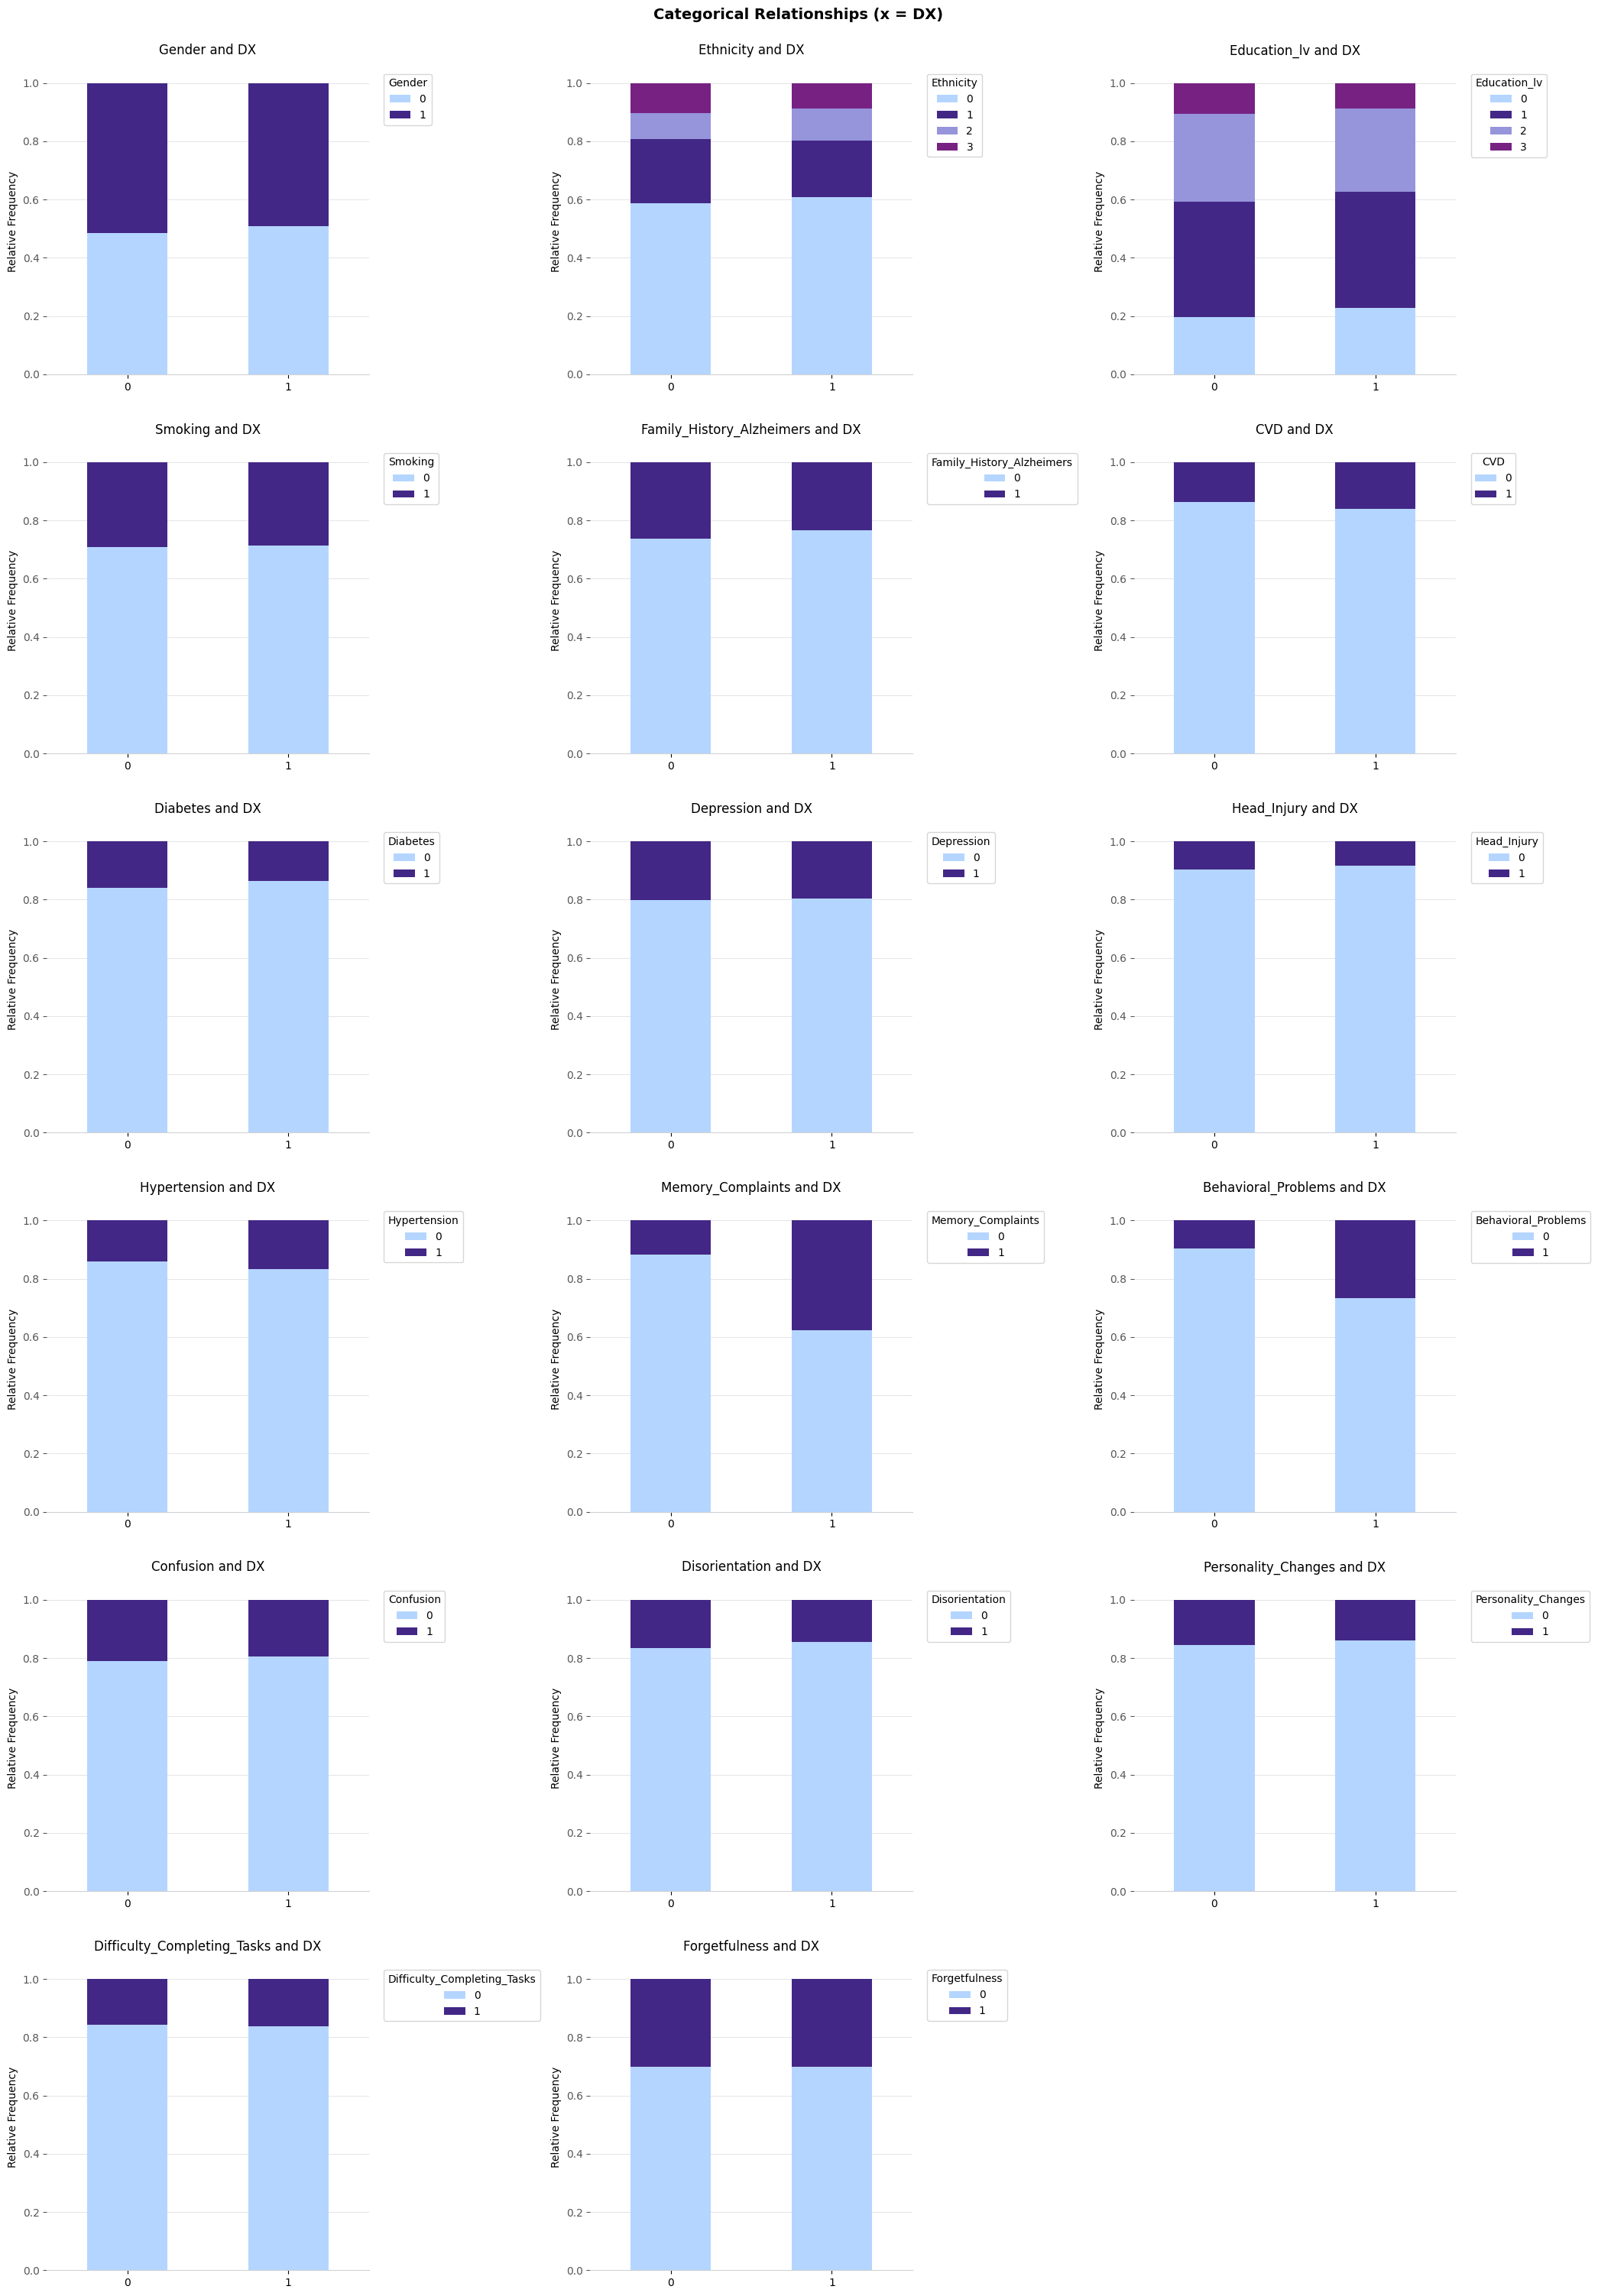

In [21]:
plot_categorical_relationship_stacked(df_main, 'DX', categorical_main, relative = True, palette = palette);

In [31]:
def plot_categorical_relationship(df, cat_col1, cat_col2, *, relative = False, show_values = False, size_group = 5, rotation = 45, palette = 'viridis'):
    '''
    Generates bar plots to visualize the relationship between two categorical columns in a DataFrame. It also shows the frequency (or relative frequency) of each combination of categories in `cat_col1` and `cat_col2`. 
    If there are too many categories in `cat_col1`, the plot is divided into multiple subplots for better visualization. Additionally, it can rotate x-axis labels and display values on the bars if requested.

    Parameters:
        df (pd.DataFrame): 
            The DataFrame containing the data for the plot.
        cat_col1 (str): 
            The name of the categorical column in the DataFrame to be used for the x-axis.
        cat_col2 (str): 
            The name of the categorical column in the DataFrame to differentiate the bars in the plot (through color).
        relative (bool, optional): 
            If True, frequencies will be displayed as relative proportions instead of absolute counts. Default is False.
        show_values (bool, optional): 
            If True, values will be annotated on top of the bars. Default is False.
        size_group (int, optional): 
            Maximum number of categories to display in a single plot. If there are more categories, they will be split into multiple plots. Default is 5.
        rotation (int, optional): 
            Angle of rotation for x-axis labels. Default is 45 degrees.
        palette (str, optional): 
            Color palette to use in the plot. Default is 'viridis'. If set to an empty string, the default Seaborn palette will be used.

    Returns:
        None: The function displays the plot and does not return any value.
    '''
    
    # Prepare the data
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name = 'count')
    total_counts = df[cat_col1].value_counts()
    
    # Calculate relative frequencies if specified
    if relative:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis = 1)
    
    if palette == '':
        palette = 'viridis'

    # If there is more than size_group categories in cat_col1, they get divided into size_group groups
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Select subgroup of categories for each plot
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Create plot
            plt.figure(figsize = (10, 6))
            ax = sns.barplot(x = cat_col1, y = 'count', hue = cat_col2, data = data_subset, order = categories_subset, palette = adjust_palette(palette, df[cat_col2].nunique()))
            
            # Set the title, ticks, grid and spine
            ax.set_title(f'Relationship between {cat_col1} and {cat_col2} - Group {i + 1}')
            ax.set_xlabel(cat_col1)
            ax.set_ylabel('Relative Frequency' if relative else 'Count')
            ax.tick_params(colors = '#565656')
            ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
            ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
            ax.set_axisbelow(True)
            ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

            if show_values:
                # Annotate each bar with its height (the frequency value)
                for p in ax.patches:
                    if p.get_xy() != (0,0):
                        height = p.get_height()
                        ax.annotate(f'{height:.2f}' if relative else f'{height:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                    ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, size_group),
                                    textcoords = 'offset points')

            # Display plots
            plt.show()
    else:
        # Creates plot for less than size_group categories
        plt.figure(figsize = (10, 6))
        ax = sns.barplot(x = cat_col1, y = 'count', hue = cat_col2, data = count_data, palette = adjust_palette(palette, df[cat_col2].nunique()))
        
        # Set the title, ticks, grid and spine
        ax.set_title(f'Relationship between {cat_col1} and {cat_col2}')
        ax.set_xlabel(cat_col1)
        ax.set_ylabel('Relative Frequency' if relative else 'Count')
        ax.tick_params(colors = '#565656')
        ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
        ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
        ax.set_axisbelow(True)
        ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

        if show_values:
            # Annotate each bar with its height (the frequency value)
            for p in ax.patches:
                if p.get_xy() != (0,0):
                    height = p.get_height()
                    ax.annotate(f'{height:.2f}' if relative else f'{height:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, size_group),
                                textcoords = 'offset points')
        # Legend
        legend = plt.legend(title = cat_col2, title_fontsize = 'small', framealpha = 1, fontsize = 'small', edgecolor = '#565656', borderpad = 1, loc = 'best')
        legend.get_frame().set_linewidth(0.8)
  
        # Display plot
        # plt.tight_layout()
        plt.show()

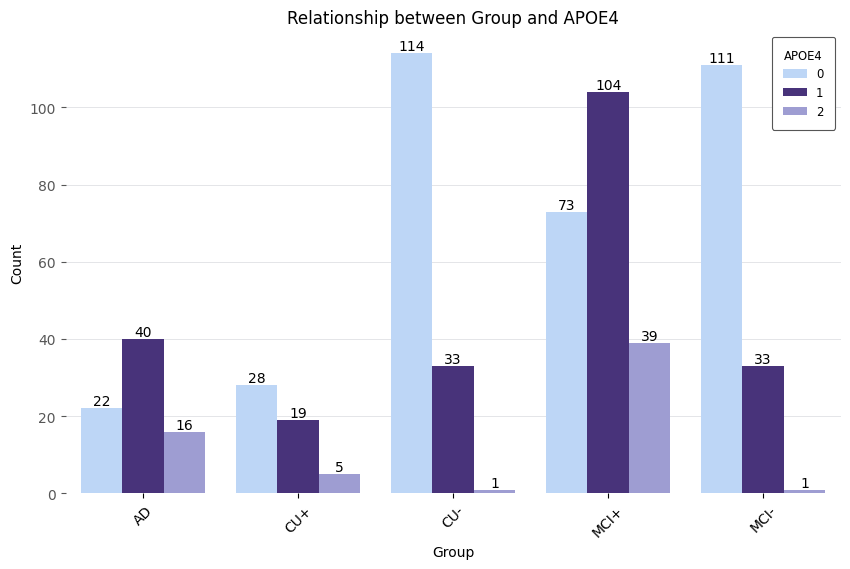

In [32]:
plot_categorical_relationship(df_adni, 'Group', 'APOE4', relative=False, show_values = True,palette = palette)

### Numerical functions

In [ ]:
def plot_combined_numerical_distribution(df, columns, *, kde=True, boxplot=False, whisker_width=1.5, bins=None):
    """
    Plots a combined visualization of histograms with optional KDE curves and boxplots for specified numerical columns in a DataFrame. It generates a grid of subplots where each row corresponds to a specified column.
    If `boxplot` is True, the first subplot in each row is a histogram (optionally with a KDE curve) and the second is a boxplot.  If `boxplot` is False, only the histogram (with optional KDE) is displayed.
    

    Parameters:
        df : pandas.DataFrame
            The DataFrame containing the data to plot.
        columns : list of str
            A list of column names to plot. Each column should be numerical.
        kde : bool, optional, default=True
            Whether to plot a KDE (Kernel Density Estimate) line alongside the histogram.
        boxplot : bool, optional, default=False
            Whether to include a boxplot alongside the histogram for each column.
        whisker_width : float, optional, default=1.5
            The width of the whiskers in the boxplot. Controls the extent of the whiskers relative to the IQR (Interquartile Range).
        bins : int or str, optional, default=None
            The number of bins to use for the histogram. If None, the number of bins will be determined automatically.

    Returns:
        None
            Displays the plots.
    """

    # Determine the number of columns to plot
    n_columns = len(columns)
    
    if n_columns:
        # Create the base figure and a grid of subplots. If boxplots are requested, use 2 columns, otherwise 1.
        if not boxplot:
            fig, axs = plt.subplots(n_columns, 1, figsize = (5, 5 * n_columns))
        else:
            fig, axs = plt.subplots(n_columns, 2, figsize = (10, 5 * n_columns))
        
        # Ensure axs is a 1D array, even if there's only one subplot
        axs = np.atleast_1d(axs).flatten()
        
        # Loop through each specified column to create the plots
        for i, column in enumerate(columns):
            # Check if the column is of a numerical data type
            if df[column].dtype in ['int64', 'float64']:
                # Histogram and optional KDE curve
                ax = axs[i * (2 if boxplot else 1)]
                sns.histplot(df[column], kde = kde, ax = ax, bins = 'auto' if bins is None else bins, color = '#74BBFF', alpha = 0.4)
                
                # If KDE is enabled, modify the line color for better visibility
                if kde:
                    for line in ax.lines:
                        line.set_color('#004aad')
                
                # Set title, tick parameters, and customize axis appearance
                ax.set_title(f'Histogram and KDE of {column}' if kde else f'Histogram of {column}')
                ax.tick_params(colors = '#565656')
                ax.set_axisbelow(True)
                ax.spines[['right', 'top']].set_visible(False)
                ax.spines[['left', 'bottom']].set_color('#565656')
               
                # If boxplots are requested, create a boxplot next to the histogram
                if boxplot:
                    ax = axs[i * 2 + 1]
                    sns.boxplot(x = df[column], ax = ax, whis = whisker_width, color = '#74BBFF', linecolor = 'black', linewidth = 0.8)
                    
                    # Set title, tick parameters, and customize axis appearance for the boxplot
                    ax.set_title(f'Boxplot of {column}')
                    ax.tick_params(colors='#565656')
                    ax.spines[['right', 'top', 'left']].set_visible(False)
                    ax.spines[['bottom']].set_color('#565656')
                    
        # Set the overall title for the figure
        plt.suptitle('Histograms and Boxplots' if boxplot else 'Histograms', ha='center', y=1, fontproperties={'weight': 600, 'size': 14})
        # Adjust layout to avoid overlap
        plt.tight_layout(h_pad=3, w_pad=3)
        # Display the final plots
        plt.show()


In [ ]:
plot_combined_numerical_distribution(df_bm, numerical_bm, kde = True, boxplot = True, bins = 30)

### REVIEW AND UPDATE

In [ ]:
def custom_scatter_plot(df, x, y, color_col = None, size_col = None, scale = 1, legend = 'auto'):
    fig, ax = plt.subplots(figsize = (20, 10))
        
    # Scatter plot
    if type(size_col) == str:
        if size_col != '':
            if color_col:
                sp = plt.scatter(x = df[x], y = df[y], c = df[color_col], s = df[size_col] * scale, cmap = 'viridis', alpha = 0.5)
            else:
                sp = plt.scatter(x = df[x], y = df[y], s = df[size_col] * scale, cmap = 'viridis', alpha = 0.5)
        elif color_col:
            sp = plt.scatter(x = df[x], y = df[y], c = df[color_col], cmap = 'viridis', alpha = 0.5)
    else:
        plt.scatter(x = df[x], y = df[y], s = df[size_col] * scale, cmap = 'viridis', alpha = 0.5)
    
    # Legend
    handles, labels = sp.legend_elements('sizes', num = 6)
    for handle in handles:
        handle.set_markerfacecolor('#CCCCCC')
        handle.set_markeredgecolor('#CCCCCC')
    
    if legend == 'colorbar':
        plt.legend(handles, labels, ncol = 3, title = size_col, title_fontsize = 'small', fontsize = 'small', frameon = False, loc = 'upper right', labelspacing = 2)
        plt.colorbar(label = f'{color_col}')
        # plt.clim(df[color_col].min(), df[color_col].max()) # No hacer esto, porque tendría en cuenta los outliers y descolocaría el resto de colores
        plt.clim(0, 7)
    else:  
        plt.legend(handles, labels, ncol = 3, title = size_col, title_fontsize = 'small', fontsize = 'small', frameon = False, loc = 'upper right', labelspacing = 2)
    
    # Figure presentation
    if legend == 'colorbar': # This fixes title horizontal alignment (not centered in colorbar option)
        plt.suptitle(f'Scatter plot: {x}, {y}{(f', {color_col}') if color_col else ''}{(f', {size_col}') if size_col else ''}', x = 0.47, y = 0.92, weight = 'bold') 
    else:
        plt.suptitle(f'Scatter plot: {x}, {y}{(f', {color_col}') if color_col else ''}{(f', {size_col}') if size_col else ''}', x = 0.5, y = 0.92, weight = 'bold')
        
    plt.xlabel(x)
    plt.ylabel(y)
    ax.spines[['top', 'right', 'bottom', 'left']].set_color('#d3d3d3')
    ax.tick_params(colors = '#565656')

In [ ]:
def edu_clasif(years):
    if years > 18:
        level = 'Higher'
    elif years >= 16:
        level = 'Bachelors'
    elif years >= 12:
        level = 'High School'
    else:
        level = 'None'
    return level

In [ ]:
def bar_donut_chart(df, variable):
    colors = ['#6CB4EE', '#318CE7', '#6495ED', '#87CEFA'] 

    category_counts = df[variable].value_counts()

    fig, axs = plt.subplots(1, 2, figsize = (14, 4)) 

    bars = axs[0].barh(category_counts.index, category_counts.values, color = colors)
    axs[0].set_title(f'{variable} Distribution', fontsize = 16)
    axs[0].set_xlabel('Count')
    axs[0].set_ylabel(f'{variable} Types')

    for bar, value in zip(bars, category_counts.values):
        width = bar.get_width()
        axs[0].text(width, bar.get_y() + bar.get_height() / 2, '%d' % int(width),
                    ha = 'left', va = 'center', color = 'black', fontsize = 10)

    status_counts = df[variable].value_counts()

    wedges, texts, autotexts = axs[1].pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)

    centre_circle = plt.Circle((0,0),0.70,fc = 'white')
    plt.gca().add_artist(centre_circle)
    axs[1].axis('equal')

    plt.tight_layout()
    plt.show()